# 时间序列的交叉训练并进行验证(50条航线）
1. 交叉训练
2. 构建时间序列进行预测，并进行验证
3. 固定搜索日期，预测提前15天票价信息，比如哪一天买最便宜

In [2]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import time
import re # 正则表达式
from matplotlib.dates import AutoDateLocator,DateFormatter

In [3]:
inputfile='../datasets/top500_airroute_feature_preprocessed_1.csv' # 训练的数据结构及预测一天
model_file='../model/top500_airroute_timeseries_xgb_cv_1.pkl'             # 模型文件

In [8]:
%time data=pd.read_csv(inputfile,parse_dates=['dep_date','search_date']) #读取文件时自动转换日期格式

CPU times: user 20.5 s, sys: 1.24 s, total: 21.8 s
Wall time: 21.7 s


In [9]:
df = data.copy()

In [12]:
df.sort_values(by=['label','search_date','dep_date'],inplace=True)

In [20]:
dep = df[df.label==0].search_date.value_counts()
print(dep[dep==45].index.min(),dep[dep==45].index.max())

2016-01-16 00:00:00 2018-05-24 00:00:00



第一轮训练：42.930573  
只保留历史价格特征：  


In [21]:
# 训练特征
train_feature=df.columns.drop(['minprice','dep_date','search_date','arr_city','dep_city','route'])
len(train_feature)

70

## 构建交叉训练集
交叉验证根据时间顺序将训练集划分为6-fold，刚好预测7天的数  
fold1: train[1],test[2]  
fold2: train[1,2],test[3]  
fold3: train[1,2,3],test[4]  
fold4: train[1,2,3,4],test[5]  
fold5: train[1,2,3,4.5],test[6]  
fold5: train[1,2,3,4.5,6],test[7]  
test 集也作为时间序列的val集对训练结果进行验证  
dep start:2016-03-01,dep end:2018-05-09

In [22]:
train1=df.loc[(df.search_date>='2016-2-1')&(df.search_date<'2016-7-1')]
train2=df.loc[(df.search_date>='2016-7-1')&(df.search_date<'2016-12-1')]
train3=df.loc[(df.search_date>='2016-12-1')&(df.search_date<'2017-6-1')]
train4=df.loc[(df.search_date>='2017-6-1')&(df.search_date<'2017-11-1')]
train5=df.loc[(df.search_date>='2017-11-1')&(df.search_date<'2018-5-1')]
print('整体数据集：',df.shape, '\n训练集1：',train1.shape,
      '\n训练集2：',train2.shape,'\n训练集3：',train3.shape,
     '\n训练集4：',train4.shape,'\n训练集5：',train5.shape )
# print('model.best_iteration:',model.best_iteration)
#     print('model.best_score:',model.best_score)

整体数据集： (2031800, 76) 
训练集1： (339750, 76) 
训练集2： (344250, 76) 
训练集3： (409500, 76) 
训练集4： (344250, 76) 
训练集5： (407250, 76)


In [33]:
# 第一轮训练
train_df=pd.concat([train1, train2, train3, train4])
test_df=train5
%time model=fit_evaluate(train_df,test_df)
print('第一轮训练：',model.best_iteration,model.best_score)

[0]	train-rmse:700.102	test-rmse:691.207
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:679.458	test-rmse:670.885
[2]	train-rmse:659.411	test-rmse:651.148
[3]	train-rmse:639.973	test-rmse:632.022
[4]	train-rmse:621.123	test-rmse:613.45
[5]	train-rmse:602.843	test-rmse:595.44
[6]	train-rmse:585.144	test-rmse:577.997
[7]	train-rmse:567.961	test-rmse:561.077
[8]	train-rmse:551.306	test-rmse:544.711
[9]	train-rmse:535.157	test-rmse:528.794
[10]	train-rmse:519.504	test-rmse:513.39
[11]	train-rmse:504.351	test-rmse:498.471
[12]	train-rmse:489.641	test-rmse:484.016
[13]	train-rmse:475.38	test-rmse:469.959
[14]	train-rmse:461.557	test-rmse:456.354
[15]	train-rmse:448.193	test-rmse:443.217
[16]	train-rmse:435.204	test-rmse:430.454
[17]	train-rmse:422.619	test-rmse:418.078
[18]	train-rmse:410.443	test-rmse:406.098
[19]	train-rmse:398.623	test-rmse:394.478
[20]	train-rmse:387.174	test-rm

[191]	train-rmse:73.7258	test-rmse:82.5842
[192]	train-rmse:73.694	test-rmse:82.5906
[193]	train-rmse:73.667	test-rmse:82.5893
[194]	train-rmse:73.6406	test-rmse:82.5832
[195]	train-rmse:73.6212	test-rmse:82.5846
[196]	train-rmse:73.5976	test-rmse:82.5792
[197]	train-rmse:73.58	test-rmse:82.575
[198]	train-rmse:73.5616	test-rmse:82.5649
[199]	train-rmse:73.5434	test-rmse:82.5605
[200]	train-rmse:73.523	test-rmse:82.5561
[201]	train-rmse:73.5022	test-rmse:82.5666
[202]	train-rmse:73.4797	test-rmse:82.5686
[203]	train-rmse:73.4581	test-rmse:82.5721
[204]	train-rmse:73.4333	test-rmse:82.5709
[205]	train-rmse:73.4085	test-rmse:82.5697
[206]	train-rmse:73.3871	test-rmse:82.5681
[207]	train-rmse:73.3691	test-rmse:82.5668
[208]	train-rmse:73.3543	test-rmse:82.5647
[209]	train-rmse:73.3362	test-rmse:82.5637
[210]	train-rmse:73.32	test-rmse:82.5643
[211]	train-rmse:73.2958	test-rmse:82.562
[212]	train-rmse:73.2736	test-rmse:82.5594
[213]	train-rmse:73.2579	test-rmse:82.5551
[214]	train-rmse:73.

In [60]:
%time valdf_7 = cross_validation(model,test_df,7) #提前7天

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


验证集MAPE0.002621,3.293090：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.008148,8.915654：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015328,18.613615：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015271,15.434449：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.020969,23.778609：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.023362,28.157494：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.030696,32.971368：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.039512,41.829814：

++++++航线+++++++0.0提前7天预测，交叉验证结果：MAPE:0.019,RMSE:21.624
验证集MAPE0.004095,6.122817：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.012413,27.073152：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.019492,41.535527：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.026984,52.422641：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.032444,59.525158：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.031048,63.8

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.073447,37.556180：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.074272,39.408121：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.108876,61.082458：

++++++航线+++++++13.0提前7天预测，交叉验证结果：MAPE:0.069,RMSE:35.818
验证集MAPE0.053233,27.964660：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.070144,33.173617：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.076980,40.928664：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099954,43.892799：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.095898,50.258443：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.102308,52.170234：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099399,49.560289：
特征构造--相同起飞日期价格统计量，耗时：8秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.125579,76.326201：

++++++航线+++++++14.0提前7天预测，交叉验证结果：MAPE:0.090,RMSE:46.784
验证集MAPE0.014244,11.753959：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.018484,11.649511：
特征构造--相

验证集MAPE0.061083,26.960877：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.101446,95.954619：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.138933,130.131899：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.152989,131.477670：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.140649,100.202240：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.131027,98.782815：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.136977,43.340256：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.161044,60.633324：

++++++航线+++++++27.0提前7天预测，交叉验证结果：MAPE:0.128,RMSE:85.935
验证集MAPE0.089463,25.912674：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.113860,35.438209：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.120715,37.727974：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.132804,43.778483：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.121997,43.726930：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.1464

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.124207,96.186509：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.116550,28.470648：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118583,32.739035：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.126821,24.830537：

++++++航线+++++++40.0提前7天预测，交叉验证结果：MAPE:0.101,RMSE:32.044
验证集MAPE0.037249,21.502455：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.053138,26.868404：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.074674,26.907248：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111993,43.769091：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111737,49.073188：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.104559,56.784975：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.084931,50.628275：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118991,62.775792：

++++++航线+++++++41.0提前7天预测，交叉验证结果：MAPE:0.087,RMSE:42.289
验证集MAPE0.017002,15.358675：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相

In [61]:
%time valdf_7.to_csv('../datasets/valdf_7.csv',index=False)

CPU times: user 35.7 s, sys: 301 ms, total: 36 s
Wall time: 36.3 s


In [62]:
%time valdf_15 = cross_validation(model,test_df,15) #提前15天
%time valdf_15.to_csv('../datasets/valdf_15.csv',index=False)

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


验证集MAPE0.002621,3.293090：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.008148,8.915654：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015328,18.613615：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015271,15.434449：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.020969,23.778609：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.023362,28.157494：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.030696,32.971368：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.039512,41.829814：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.047281,48.298608：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.056874,56.198458：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.075427,72.686389：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.086254,75.994006：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.090566,129.136190：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.094511,82.250025：

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.096348,67.792986：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.107778,71.508197：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.115123,76.710133：

++++++航线+++++++6.0提前15天预测，交叉验证结果：MAPE:0.055,RMSE:42.270
验证集MAPE0.007298,9.327379：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.030640,221.409676：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.031741,34.283135：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.042734,39.629394：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.042402,40.017219：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.062716,51.716965：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.072702,54.099291：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.082743,59.087506：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.090919,64.162814：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.100612,71.940407：
特征构造--相同起飞日期价格统计

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.135774,88.762730：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.150313,121.221927：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.187099,100.583962：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.243702,135.642094：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.197563,130.898519：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.258520,145.917633：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.269156,156.925035：

++++++航线+++++++13.0提前15天预测，交叉验证结果：MAPE:0.132,RMSE:77.327
验证集MAPE0.053233,27.964660：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.070144,33.173617：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.076980,40.928664：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099954,43.892799：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.095898,50.258443：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.102308,52.170234：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.110650,89.229293：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.126863,106.212470：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.122455,96.681838：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.128873,101.318530：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.121329,80.901586：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.123528,99.316777：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.162566,129.476296：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.188249,150.283510：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.186538,133.280656：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.187672,152.667831：

++++++航线+++++++20.0提前15天预测，交叉验证结果：MAPE:0.119,RMSE:91.950
验证集MAPE0.003989,7.663768：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.010515,13.447015：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.019114,23.480962：
特征构造--相同起飞

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.138933,130.131899：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.152989,131.477670：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.140649,100.202240：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.131027,98.782815：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.136977,43.340256：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.161044,60.633324：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.176473,63.623022：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.206881,64.073395：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.210300,64.866187：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.210331,62.931886：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.223844,74.531872：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.201307,69.774398：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.229352,83.388782：
特征构造--相同起飞日期价格统计量，耗时：7

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.213533,96.365047：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.211220,102.510704：

++++++航线+++++++33.0提前15天预测，交叉验证结果：MAPE:0.161,RMSE:75.204
验证集MAPE0.075363,31.046918：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.113655,61.807587：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.219560,82.559339：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.219702,78.550621：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.223420,79.890342：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.241076,125.792952：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.229391,83.324800：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.260728,97.953957：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.289319,105.753907：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.289299,103.415988：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.217996,66.342545：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.176491,36.263542：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.168217,32.952828：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.185412,43.789395：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.163710,31.467443：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.171950,32.107805：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.157096,27.457037：

++++++航线+++++++40.0提前15天预测，交叉验证结果：MAPE:0.133,RMSE:35.096
验证集MAPE0.037249,21.502455：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.053138,26.868404：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.074674,26.907248：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111993,43.769091：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111737,49.073188：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.104559,56.784975：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.084931,50.628275：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.085309,106.143404：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.095929,148.609780：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.114187,172.586275：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.146329,197.868531：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.144138,191.401207：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.180298,217.183435：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.192609,239.893588：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.217287,264.065564：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.167747,243.615909：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.234563,292.106145：

++++++航线+++++++47.0提前15天预测，交叉验证结果：MAPE:0.119,RMSE:160.703
验证集MAPE0.054913,81.530771：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.109463,108.680265：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.112037,124.630209：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征

In [63]:
%time valdf_45 = cross_validation(model,test_df,45) #提前45天
%time valdf_45.to_csv('../datasets/valdf_45.csv',index=False)

验证集MAPE0.002621,3.293090：


/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.008148,8.915654：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015328,18.613615：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.015271,15.434449：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.020969,23.778609：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.023362,28.157494：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.030696,32.971368：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.039512,41.829814：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.047281,48.298608：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.056874,56.198458：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.075427,72.686389：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.086254,75.994006：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.090566,129.136190：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.094511,82.250025：
特征构造--相同起飞日期价格统计量，耗时：7秒
特

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.079493,126.752602：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.077061,132.532093：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.071261,125.440291：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.080586,137.786550：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.076088,147.070505：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.093893,194.402675：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.089520,184.589755：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099512,194.062533：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.109768,203.302457：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：6秒
验证集MAPE0.125180,218.062886：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.120684,164.232965：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：6秒
验证集MAPE0.153908,241.269329：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.153790,226.302845：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.188677,183.263987：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.219420,200.545423：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.242073,212.748104：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.259939,240.807669：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.300078,332.549111：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.296093,351.303794：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.242599,222.960186：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.302967,357.322823：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.331893,376.176850：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.341016,381.903013：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.352427,404.297003：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.369689,422.338516：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.385916,426.187908：

++++++航线+++++++4.0提前45天预测，交叉验证结果：MA

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.042734,39.629394：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.042402,40.017219：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.062716,51.716965：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.072702,54.099291：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.082743,59.087506：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.090919,64.162814：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.100612,71.940407：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.102152,73.152049：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.114736,91.437532：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111599,77.434130：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.125279,85.860869：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.122836,84.591699：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.130502,88.775873：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.174521,186.324627：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.212374,215.821892：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.237157,240.890893：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.209369,214.775180：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.217583,216.265269：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.214791,253.304428：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.199609,232.077382：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.199878,246.582688：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.203793,254.835110：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.246369,279.596892：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.261993,301.557734：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.143699,116.476893：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.143874,139.850237：
特征构造--相同起飞日期

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.106944,43.779244：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.109022,69.870992：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.108940,66.327973：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.110856,78.887543：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.165730,112.240120：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.163560,111.261154：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.177097,126.700697：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.171023,117.950931：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.178277,128.406300：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.170920,128.975364：

++++++航线+++++++11.0提前45天预测，交叉验证结果：MAPE:0.135,RMSE:87.769
验证集MAPE0.048246,30.520667：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.057438,30.797186：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.065185,35.718965：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.125579,76.326201：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.143568,85.984236：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.187412,95.108476：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.253585,81.487559：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.176312,88.718030：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.190200,95.018595：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.188868,100.799471：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.181587,119.185476：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.187455,122.279643：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.146630,83.620306：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.131987,65.756622：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.148081,80.191299：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.153914,85.452391：
特征构造--相同起飞日期价格统计量，耗时：7

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.109429,37.788005：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118961,50.021107：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.121279,38.897015：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.122067,47.724441：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.129568,52.762150：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.130363,46.923342：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.136019,44.144963：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.141784,57.766388：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.116550,41.887681：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.121376,48.089500：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111803,50.292036：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.104968,50.047089：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.107550,55.939253：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.243277,133.835222：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.257745,138.806580：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.267321,142.854083：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.289899,160.132515：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.315394,186.379243：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.310804,194.968032：

++++++航线+++++++18.0提前45天预测，交叉验证结果：MAPE:0.189,RMSE:90.698
验证集MAPE0.040428,41.643727：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：6秒
验证集MAPE0.055895,51.961952：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.070270,57.969341：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.097947,80.308156：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.103208,83.935293：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.115011,84.210055：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.078031,65.385014：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.088945,71.194725：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099663,77.255996：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.117980,84.093599：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.131326,90.489656：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.153541,100.188822：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.164554,109.461104：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.112009,60.824520：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.122584,76.886785：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118103,70.451717：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.122742,68.520394：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.141018,82.485150：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.148121,88.183017：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.176382,113.195504：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.170100,63.903225：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.175371,65.711829：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.185815,95.923117：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.189642,88.529719：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.145518,58.776602：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.158997,61.087369：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.168298,60.847898：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.180449,67.540112：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.188338,71.027694：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.197340,77.789602：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.191025,73.461857：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.174809,72.328571：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.173262,70.863092：
特征构造--相同起飞日期价格统计量，耗时：7秒
特

特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.228787,141.370750：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.234360,153.478844：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.237422,154.993405：

++++++航线+++++++25.0提前45天预测，交叉验证结果：MAPE:0.163,RMSE:113.198
验证集MAPE0.121713,83.086033：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.174403,102.580592：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.177360,87.757241：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.181024,88.437297：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.164327,104.901541：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.170331,91.488433：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.178320,91.082014：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.204188,113.408504：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.226726,123.151307：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.241011,125.183776：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.192861,82.958624：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.196749,92.209664：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.150753,53.677432：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.158239,62.449090：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.140378,53.326458：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.125285,52.387870：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.110879,47.115461：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118535,50.724309：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.133522,58.389116：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.160993,68.178850：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.159055,72.008641：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.166155,67.872757：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.183638,69.887688：
特征构造--相同起飞日期价格统计量，耗时：7秒
特

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.138475,79.907864：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.137622,76.441844：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.109169,60.714267：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.095336,56.096346：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.099741,70.866855：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.124920,94.033800：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.154936,135.553843：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.178048,156.009615：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.187032,169.102599：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.200289,187.800189：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.216015,200.251675：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.211701,208.568827：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.237003,226.073489：
特征构造--相同起飞日期价格统计量，

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.076861,45.149628：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.086296,43.429637：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.095504,47.595518：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.106509,52.338641：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118081,55.520767：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.135059,63.292618：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.149108,71.778827：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.161265,77.297262：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.180759,86.184685：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.372160,108.290453：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.183908,94.138904：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.201510,98.850617：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.228590,129.947682：
特征构造--相同起飞日期价格统计量，耗时：7秒

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.077972,23.082942：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.105654,34.557199：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.098780,27.403163：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.113100,33.221479：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.116018,38.682181：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.117416,35.942856：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.112141,34.174064：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.108730,31.764411：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.116774,32.834602：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.117475,31.688414：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.114036,30.653620：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.111175,28.830154：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.094272,23.480962：
特征构造--相同起飞日期价格统计量，耗时：7秒
特

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.133574,76.116285：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.135867,79.121426：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.142972,104.359422：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.144688,121.287629：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.170752,151.620799：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.188450,166.777030：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.197045,148.745420：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：6秒
验证集MAPE0.218939,197.135655：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.223144,207.339978：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.228534,217.640887：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.236750,218.727939：

++++++航线+++++++37.0提前45天预测，交叉验证结果：MAPE:0.159,RMSE:102.146
验证集MAPE0.044439,20.319121：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：6秒
验证集MAPE0.075120,36.703012：
特征构造-

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.116550,28.470648：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.118583,32.739035：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.126821,24.830537：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.134431,63.195816：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.151921,37.949967：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.176491,36.263542：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.168217,32.952828：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.185412,43.789395：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.163710,31.467443：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.171950,32.107805：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.157096,27.457037：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.138755,24.619324：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.148039,34.361477：
特征构造--相同起飞日期价格统计量，耗时：7秒
特

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.181509,247.343126：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.205083,230.670279：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.216150,247.891509：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.235756,270.363582：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.237650,264.859879：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.241199,271.835081：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.258941,290.254792：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.247743,228.050189：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.257129,253.114686：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.145932,122.401797：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.146639,126.909241：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.164693,142.930286：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.170612,147.250429：
特征构造--相同起飞日期

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.150738,51.708585：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.163325,54.585509：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.167365,56.669804：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.167319,59.675055：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.198724,78.659065：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.224942,95.447368：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.237057,100.451757：

++++++航线+++++++44.0提前45天预测，交叉验证结果：MAPE:0.126,RMSE:52.825
验证集MAPE0.015466,32.252476：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.024837,45.497497：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.053991,110.529936：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.078660,120.301381：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.103616,165.590928：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.107535,151.834925：
特征构造--相同起飞

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.146329,197.868531：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.144138,191.401207：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.180298,217.183435：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.192609,239.893588：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.217287,264.065564：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.167747,243.615909：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.234563,292.106145：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.183688,267.390684：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.184079,272.412922：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.174089,278.000959：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.180068,264.706294：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.217448,345.314221：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.218517,291.032797：
特征构造--相同起飞日期

特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.169827,178.551206：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.190679,224.465340：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.203712,263.002112：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.216020,294.974613：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.277476,414.016962：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.282450,420.531780：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.163061,231.504452：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.149411,193.781377：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.152143,204.074714：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.132816,158.041204：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.135176,137.517918：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.150211,158.965125：
特征构造--相同起飞日期价格统计量，耗时：7秒
特征构造--相同起飞日期价格统计量，耗时：7秒
验证集MAPE0.167535,196.304242：
特征构造--相同起飞日期

In [46]:
valdf_7 = pd.read_csv('../datasets/valdf_7.csv')

In [47]:
valdf_7.head()

,dep_date,search_date,pre_day,dep_city,arr_city,minprice,route,label,history_1d_by_dep_price,history_2d_by_dep_price,...,history_1w_by_preday_rise_count,history_2w_by_preday_mean,history_2w_by_preday_var,history_2w_by_preday_min,history_2w_by_preday_max,history_2w_by_preday_median,history_2w_by_preday_mode,history_2w_by_preday_decline_count,history_2w_by_preday_rise_count,pred
0,2017-11-01,2017-11-01,0,三亚,上海,390.0,三亚-上海,0.0,390.0,390.0,...,0,390.000000,0.000000,390.0,390.0,390.0,390.0,0,0,411.0
1,2017-11-02,2017-11-01,1,三亚,上海,390.0,三亚-上海,0.0,390.0,390.0,...,0,390.000000,0.000000,390.0,390.0,390.0,390.0,0,0,395.0
2,2017-11-03,2017-11-01,2,三亚,上海,390.0,三亚-上海,0.0,390.0,390.0,...,0,390.000000,0.000000,390.0,390.0,390.0,390.0,0,0,391.0
3,2017-11-04,2017-11-01,3,三亚,上海,390.0,三亚-上海,0.0,390.0,390.0,...,1,390.133333,0.266667,390.0,392.0,390.0,390.0,1,1,391.0
4,2017-11-05,2017-11-01,4,三亚,上海,390.0,三亚-上海,0.0,390.0,390.0,...,0,390.000000,0.000000,390.0,390.0,390.0,390.0,0,0,391.0


*****************三亚-上海*****************
*****************三亚-哈尔滨*****************
*****************三亚-成都*****************
*****************三亚-昆明*****************
*****************三亚-杭州*****************
*****************三亚-深圳*****************
*****************三亚-西安*****************
*****************三亚-郑州*****************
*****************三亚-重庆*****************
*****************三亚-长沙*****************
*****************上海-乌鲁木齐*****************
*****************上海-兰州*****************
*****************上海-北京*****************
*****************上海-南宁*****************
*****************上海-厦门*****************
*****************上海-哈尔滨*****************
*****************上海-大连*****************
*****************上海-天津*****************
*****************上海-太原*****************
*****************上海-广州*****************
*****************上海-成都*****************
*****************上海-昆明*****************


/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


*****************上海-沈阳*****************
*****************上海-泉州*****************
*****************上海-海口*****************
*****************上海-深圳*****************
*****************上海-珠海*****************
*****************上海-石家庄*****************
*****************上海-福州*****************
*****************上海-西安*****************
*****************上海-贵阳*****************
*****************上海-重庆*****************
*****************上海-长春*****************
*****************上海-长沙*****************
*****************上海-青岛*****************
*****************丽江-昆明*****************
*****************丽江-西安*****************
*****************丽江-重庆*****************
*****************乌兰浩特-北京*****************
*****************乌鲁木齐-上海*****************
*****************乌鲁木齐-伊宁*****************
*****************乌鲁木齐-兰州*****************
*****************乌鲁木齐-北京*****************
*****************乌鲁木齐-和田*****************
*****************乌鲁木齐-喀什*****************
*****************乌鲁木齐-广州*****************
*****************乌鲁木齐-成

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


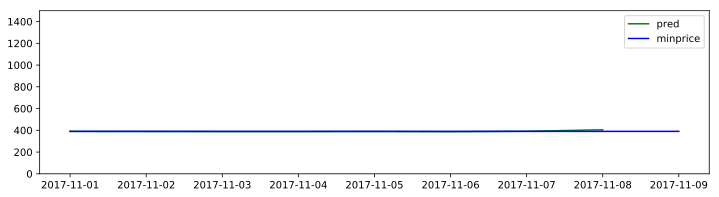

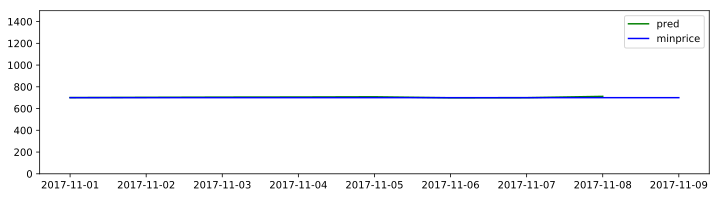

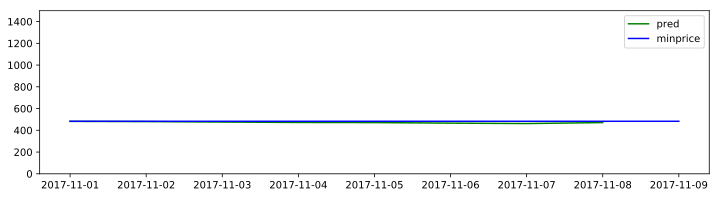

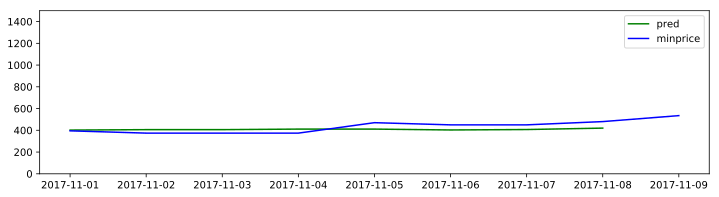

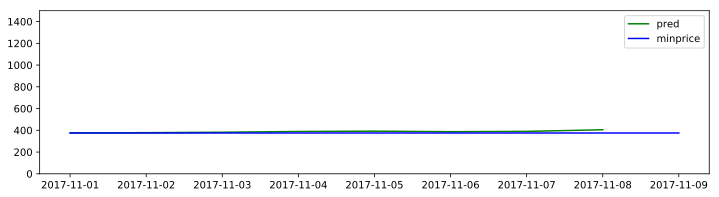

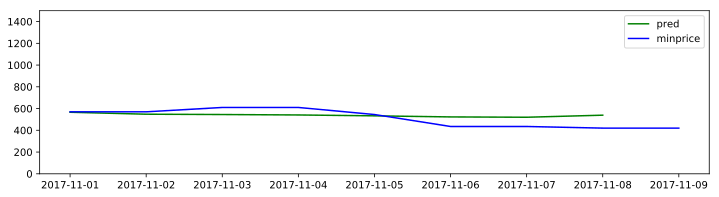

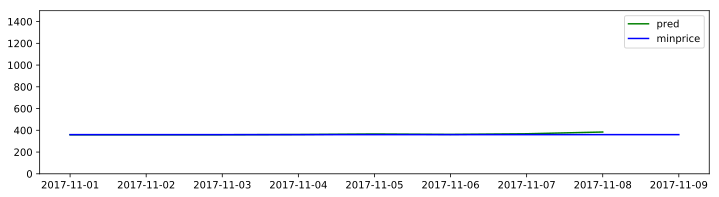

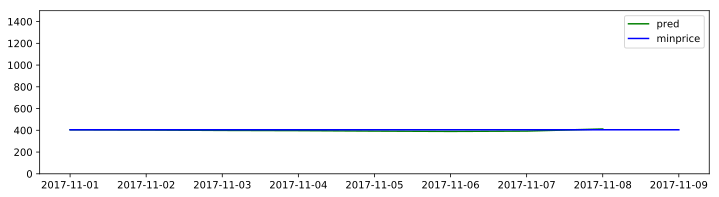

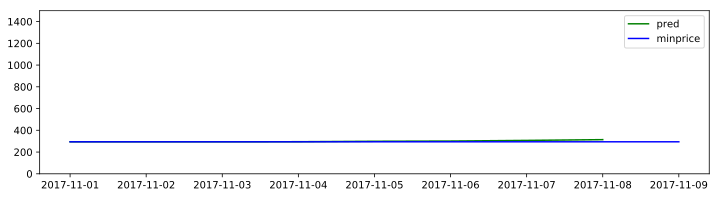

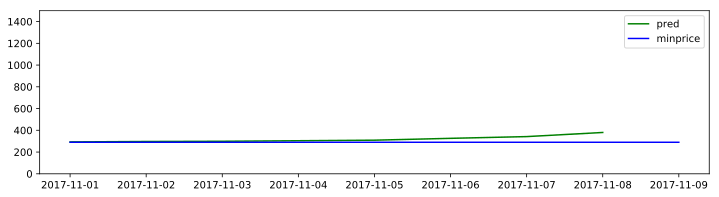

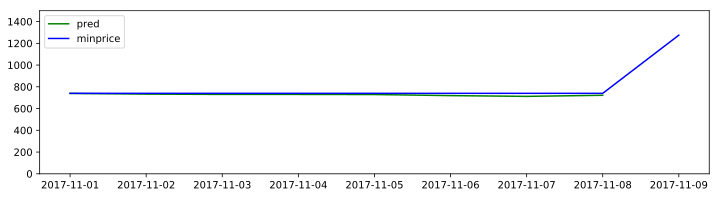

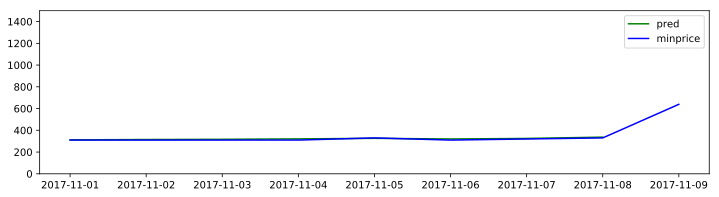

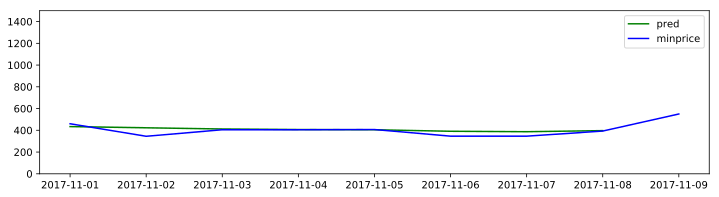

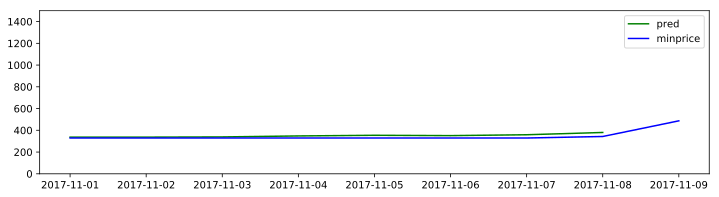

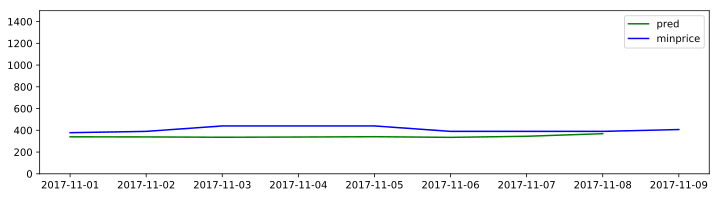

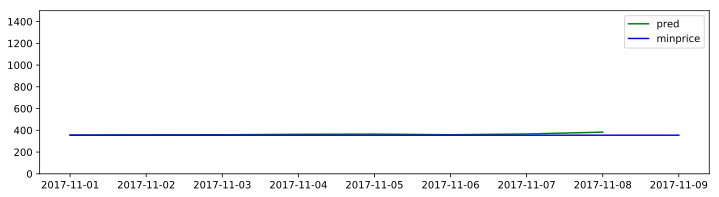

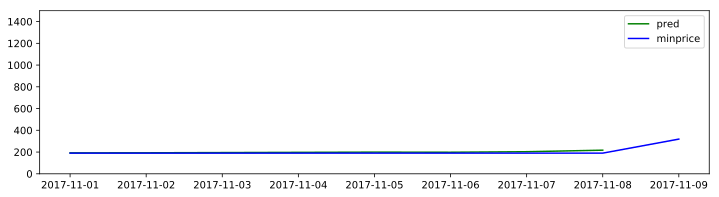

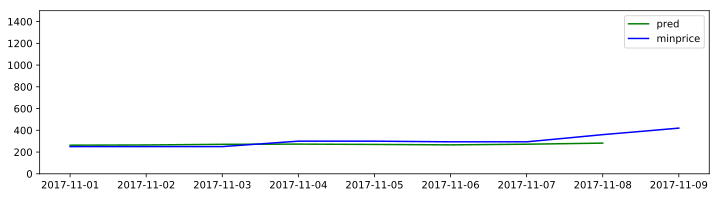

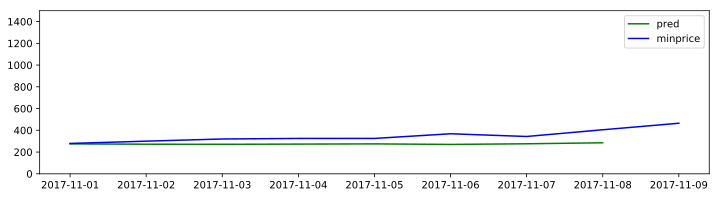

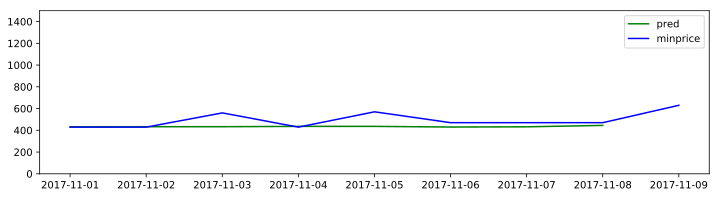

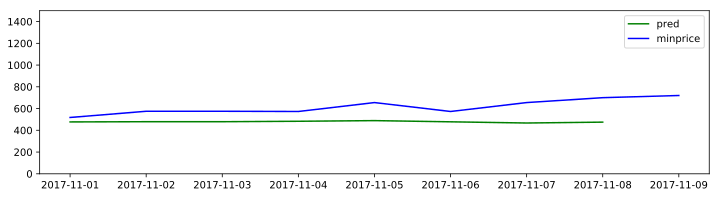

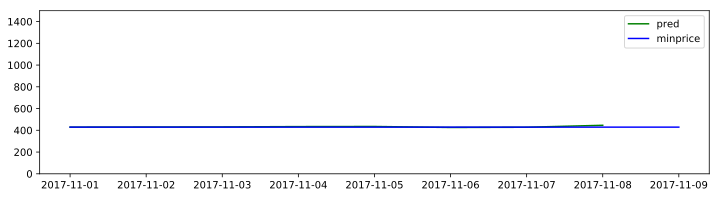

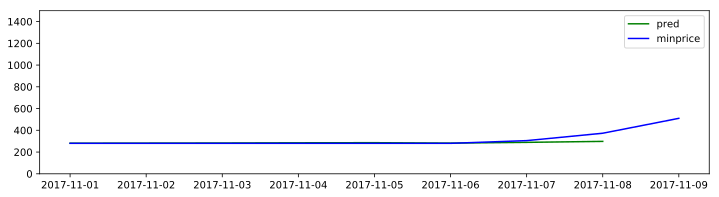

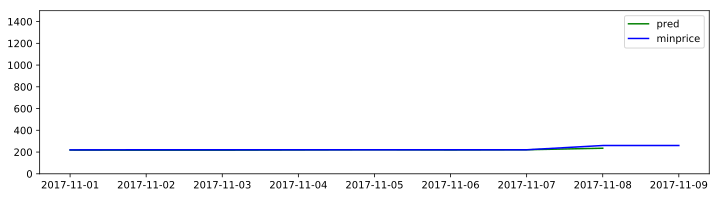

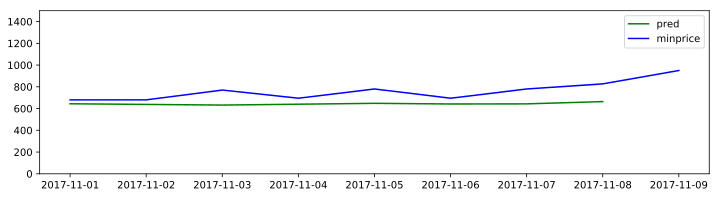

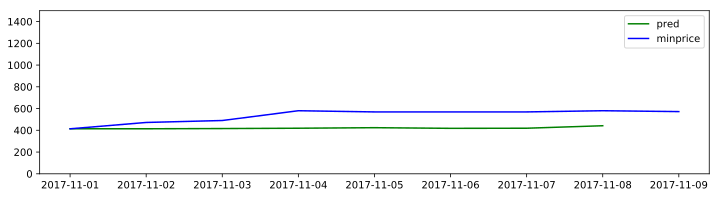

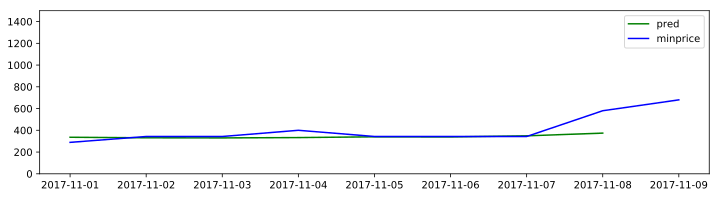

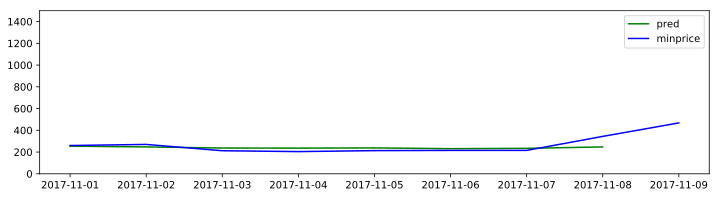

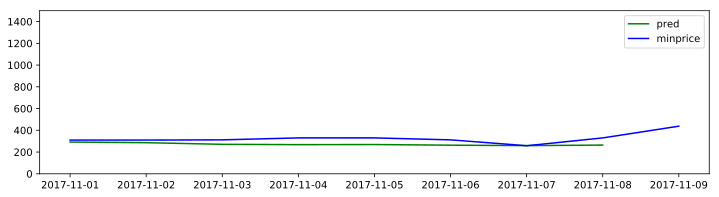

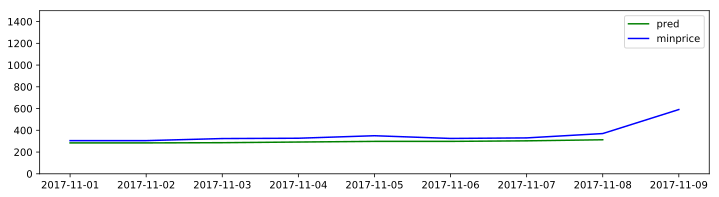

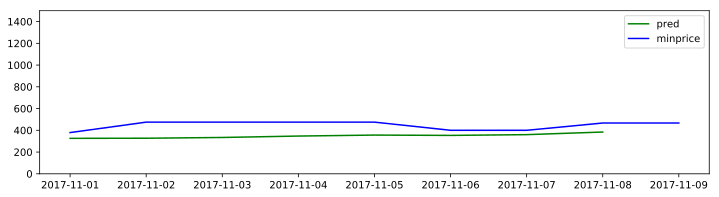

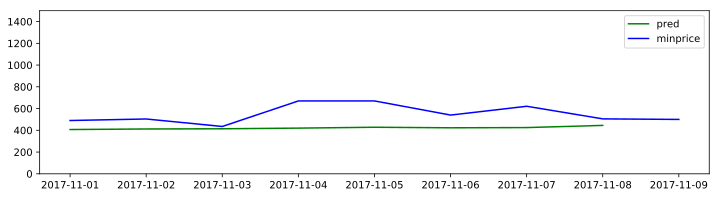

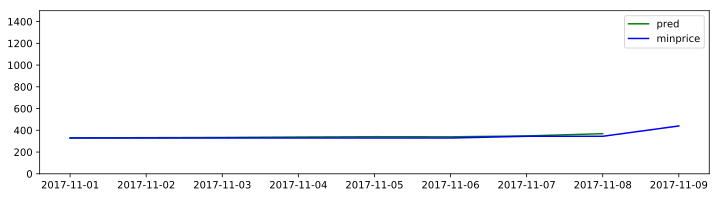

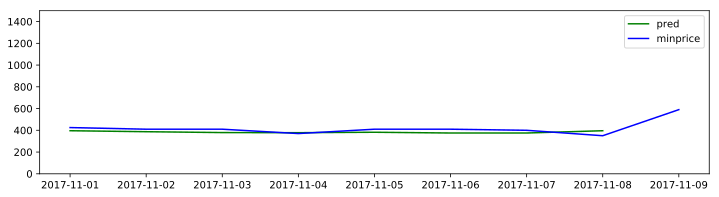

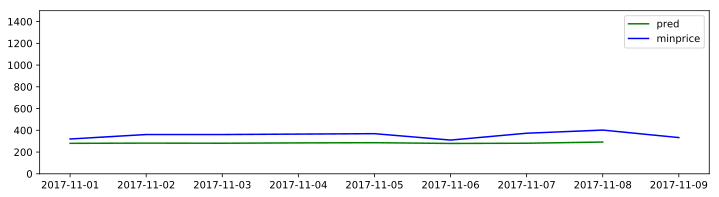

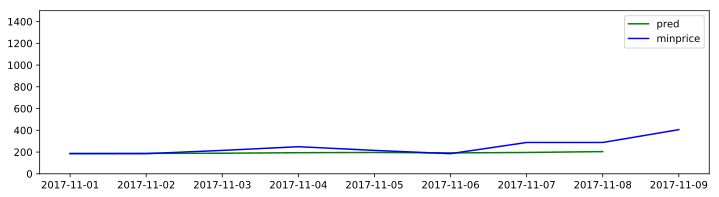

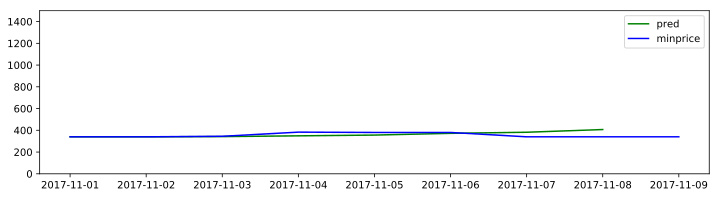

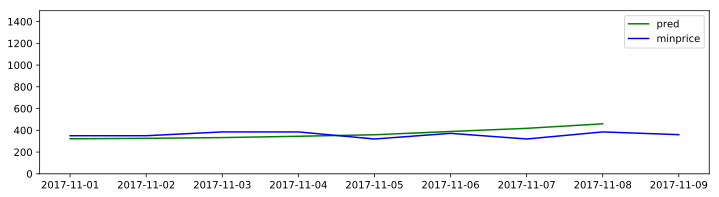

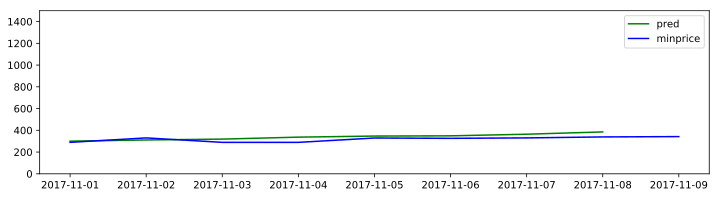

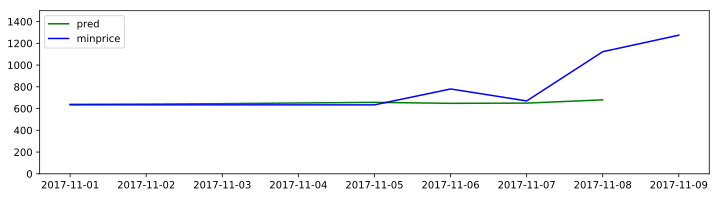

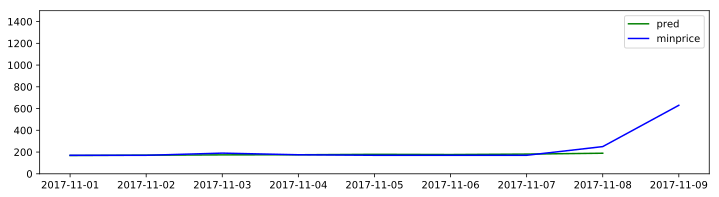

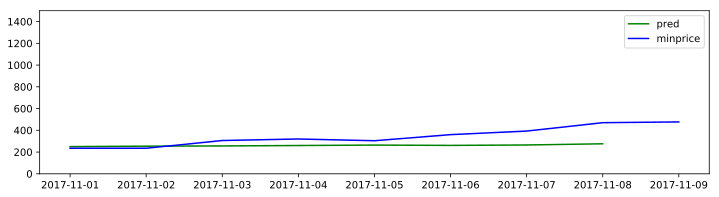

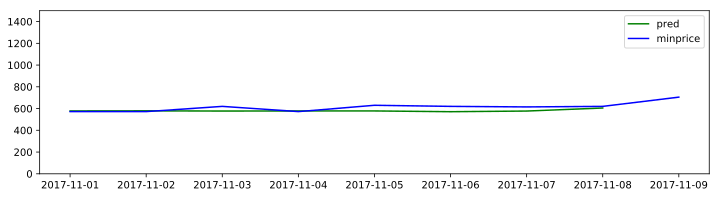

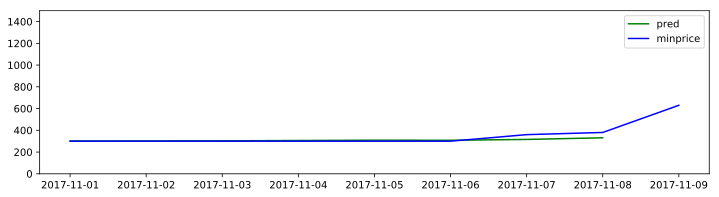

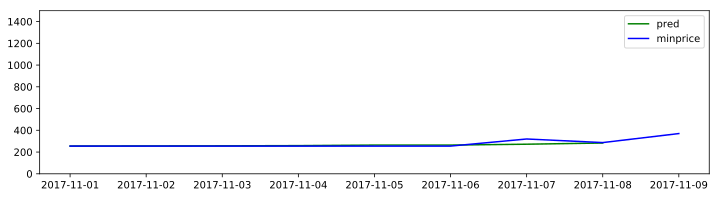

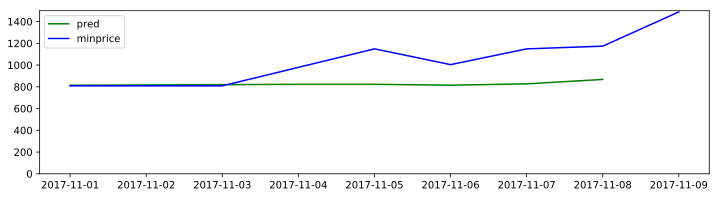

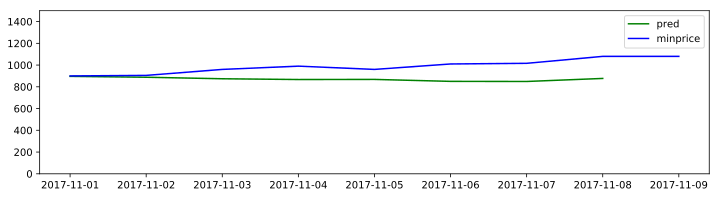

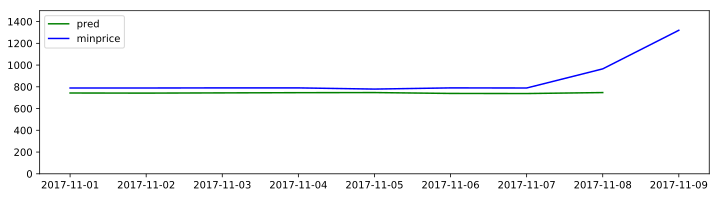

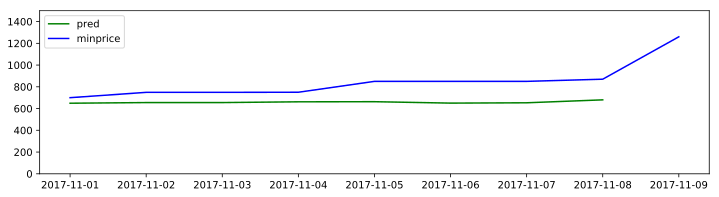

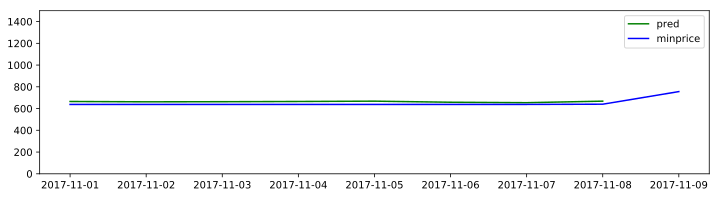

In [73]:
#绘制时间序列图
ts='2017-11-09'
valdf = valdf_7
for route in valdf.route.unique():
    print('*****************%s*****************'%route)
    result=valdf.loc[(valdf.dep_date==ts)&(valdf.route == route),['minprice','pred','pre_day','search_date']]
    plt.figure(figsize=(12,3))
    result.sort_values(by='pre_day',inplace=True)
    plt.plot(result.search_date,result.pred,color='green')
    plt.plot(result.search_date,result.minprice,color='blue')
    plt.ylim(0,1500)
    plt.legend(fontsize=10)

# 公共函数

In [25]:
def fit_evaluate(train_df,test_df):
    train_X=train_df[train_feature]
    train_y=train_df['minprice']
    test_X=test_df[train_feature]
    test_y=test_df['minprice']
    model_xgb = xgboost_model_train(train_X,train_y,test_X,test_y)   
    #模型保存
    return model_xgb

In [59]:
#days：预测的未来搜索天数
def cross_validation(model_xgb,df,days):
#     按照航线分开处理
    label_list = df.label.unique()
    res = pd.DataFrame()
    for route_num in label_list:
        valdf = df[df.label==route_num]
        #取验证集最小值为出发日期，历史15天的数据都有
        sday=valdf.search_date.min() 
        X=valdf.loc[(valdf['search_date']==sday),train_feature]
        val=xgb.DMatrix(X)
        pred=np.round(model_xgb.predict(val,ntree_limit = model_xgb.best_iteration))
        real=valdf.loc[(valdf.search_date==sday),'minprice'].values
        valdf.loc[valdf.search_date==sday,'pred']=pred
        a,b = mape_rmse(real,pred)
        loss_mape=[a]
        loss_rmse=[b]
        ts=sday
        p=[pred] # 将每次预测的结果存入列表中
        for i in range(days):
            ts=ts+timedelta(1)
            k = (i)%15
            for j in range(k+1): # 最多只有15天，只需要历史15天的数据
                ps=pd.Series(p[-j-1]) #将上次的预测结果转换为Series类型
                valdf.loc[valdf['search_date']==ts,columns_15d_by_preday[j]]=ps.values
                valdf.loc[valdf['search_date']==ts,columns_15d_by_dep[j]]=ps.shift(-1).values
            ##增加统计量的信息
            valdf=stats_feature(valdf)
            X=valdf.loc[(valdf['search_date']==ts),train_feature]
            val=xgb.DMatrix(X)
            pred=np.round(model_xgb.predict(val,ntree_limit = model_xgb.best_iteration))
            valdf.loc[valdf.search_date==ts,'pred']=pred
            real=valdf.loc[(valdf.search_date==ts),'minprice'].values
            a,b = mape_rmse(real,pred)
            loss_mape.append(a)
            loss_rmse.append(b)
            #预测完赋值给第二天
            p.append(pred)
        #将预测结果输出到文件中，计算评价损失
#         print('真实值数量：%s,预测值数量：%s'%(valdf.minprice.shape[0],len(p)))
        print('\n++++++航线+++++++%s提前%s天预测，交叉验证结果：MAPE:%.3f,RMSE:%.3f'%(route_num,days,np.mean(loss_mape),np.mean(loss_rmse)))
        res = res.append(valdf)
    return res

In [30]:
# 打印结果
def plotres(resultdf):
    ts='2017-11-03'
    data=valdf.loc[valdf.dep_date==ts,['minprice','pred','search_date']]
    plt.plot(data.minprice,data.search_date)

In [31]:
def mape_rmse(real,pred):
    mape=np.mean(np.abs(pred-real)/real)
    rmse=math.sqrt(mean_squared_error(real, pred))
    print('验证集MAPE%3f,%3f：'%(mape,rmse))    
    return mape,rmse    

#  -------------------特征处理函数-----------------------

In [32]:
def xgboost_model_train(train_X,train_y,test_X,test_y):
    # 模型训练
    xgb_train  = xgb.DMatrix(train_X, train_y)
    xgb_test   = xgb.DMatrix(test_X, test_y)
    params_xgb = {
#         'booster': 'gbtree',                # 取决于使用哪种booster,有两中模型可以选择gbtree和gblinear。gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算
        'objective': 'reg:linear',     # 定义学习任务及相应的学习目标，可选的目标函数如下：“reg:linear” —— 线性回归,“reg:logistic”—— 逻辑回归。
        #'multi:softmax'
        'gamma': 0.03,                      # 最小损失减少，模型在默认情况下，对于一个节点的划分只有在其loss function 得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值
        'max_depth': 8,                     # 数的最大深度。缺省值为6，树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合
        'lambda': 4,                        # L2 正则的惩罚系数
        'subsample': 0.8,                   # 用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中随机的抽取出50%的子样本建立树模型，这能够防止过拟合。
        'colsample_bytree': 0.8,            # 在建立树时对特征采样的比例。缺省值为1。
#         'eval_metric':'mape_ln',
        'min_child_weight': 8.5,            # 孩子节点中最小的样本权重和，在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
        'silent': 1,                        # 取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0。
        'eta': 0.03,                        # 为了防止过拟合，更新过程中用到的收缩步长。通常最后设置eta为0.01~0.2
        'seed': 1000}                       # 随机数的种子。缺省值为0。
    num_boost_round = 2000
    plst  = params_xgb.items()
    model_xgb = xgb.train(plst, xgb_train, num_boost_round,evals=[(xgb_train,'train'),(xgb_test,'test')],early_stopping_rounds=50,verbose_eval=True)
    return model_xgb
# ############################################################################
reg = re.compile('\s+|\t|\n') # 正则匹配空格、Tab键、换行
#列名同一出发日期历史15天每天票价
col_15d_by_dep='''history_1d_by_dep_price,history_2d_by_dep_price,history_3d_by_dep_price,history_4d_by_dep_price
    ,history_5d_by_dep_price,history_6d_by_dep_price,history_7d_by_dep_price,history_8d_by_dep_price
    ,history_9d_by_dep_price,history_10d_by_dep_price,history_11d_by_dep_price,history_12d_by_dep_price
    ,history_13d_by_dep_price,history_14d_by_dep_price,history_15d_by_dep_price'''
columns_15d_by_dep=re.sub(reg,'',col_15d_by_dep).split(',')    
#列名，同一提前天数历史15天每天票价
col_15d_by_preday='''history_1d_by_preday_price,history_2d_by_preday_price,history_3d_by_preday_price,
    history_4d_by_preday_price,history_5d_by_preday_price,history_6d_by_preday_price,
    history_7d_by_preday_price,history_8d_by_preday_price
    ,history_9d_by_preday_price,history_10d_by_preday_price,history_11d_by_preday_price,history_12d_by_preday_price
    ,history_13d_by_preday_price,history_14d_by_preday_price,history_15d_by_preday_price'''
columns_15d_by_preday=re.sub(reg,'',col_15d_by_preday).split(',')    
#列名，同一出发日期历史1周，2周统计量
col_by_dep_stats='''history_1w_by_dep_mean,history_1w_by_dep_var,history_1w_by_dep_min,history_1w_by_dep_max,
    history_1w_by_dep_median,history_1w_by_dep_mode,history_1w_by_dep_decline_count,
    history_1w_by_dep_rise_count,
    history_2w_by_dep_mean,history_2w_by_dep_var,history_2w_by_dep_min,history_2w_by_dep_max,
    history_2w_by_dep_median,history_2w_by_dep_mode,history_2w_by_dep_decline_count,
    history_2w_by_dep_rise_count'''
columns_by_dep_stats=re.sub(reg,'',col_by_dep_stats).split(',')

#列名，同一提前天数历史1周，2周统计量
col_by_preday_stats='''history_1w_by_preday_mean,history_1w_by_preday_var,history_1w_by_preday_min,history_1w_by_preday_max,
    history_1w_by_preday_median,history_1w_by_preday_mode,history_1w_by_preday_decline_count,
    history_1w_by_preday_rise_count,
    history_2w_by_preday_mean,history_2w_by_preday_var,history_2w_by_preday_min,history_2w_by_preday_max,
    history_2w_by_preday_median,history_2w_by_preday_mode,history_2w_by_preday_decline_count,
    history_2w_by_preday_rise_count'''
columns_by_preday_stats=re.sub(reg,'',col_by_preday_stats).split(',')  

#######统计指标总函数
def statistics_feature_engineering(data):
    df=data.copy()
    df=history_15d_by_dep_price_feature(df,columns_15d_by_dep)
    df=history_15d_by_preday_price_feature(df,columns_15d_by_preday)
    df=stats_by_dep_feature(df,columns_by_dep_stats,columns_15d_by_dep)
    df=stats_by_preday_feature(df,columns_by_preday_stats,columns_15d_by_preday)
    return df
# 同一起飞日期，搜索日期的历史15天每天价格
def history_15d_by_dep_price_feature(data,columns):
    start=time.time()
    tmp=data.copy()
    # 同一起飞日期，搜索日期的历史15天每天价格
    # 给新增的列赋值空
    for col in columns:
        tmp[col]=np.nan
    #填充历史价格信息
    dep_dates=pd.to_datetime(tmp.dep_date.unique())    
    null_count=0
    for ts in dep_dates:    
        s_date=tmp.loc[tmp.dep_date==ts,'search_date']
        for ts2 in s_date:        
            for i in range(len(columns)):
                ts_lag=ts2-timedelta(i+1)
                lagging=tmp.loc[(tmp.dep_date==ts) &(tmp.search_date==ts_lag)]['minprice']
                if lagging.empty:
#                     print('do nothing') # 历史价格为空，则不填充
                    null_count+=1 
                else:
                    tmp.loc[(tmp.dep_date==ts)&(tmp.search_date==ts2),columns[i]]=lagging.values
    end=time.time()    
#     print('特征构造-相同起飞日期，历史15天每天搜索价格特征耗时：%d秒,空值数量：%s'%((end-start),null_count))
    return tmp

# 同一提前天数，搜索日期的历史15天每天价格
def history_15d_by_preday_price_feature(data,columns):
    start=time.time()
    tmp=data.copy()    
    # 给新增的列赋值空
    for col in columns:
        tmp[col]=np.nan
    #填充历史价格信息
    dep_dates=pd.to_datetime(tmp.dep_date.unique()) 
    null_count=0
    for ts in dep_dates:    
        preday=tmp.loc[tmp.dep_date==ts,'pre_day']
        for pre in preday:        
            for i in range(len(columns)):
                ts_lag=ts-timedelta(i+1) #从0开始，要+1
                lagging=tmp.loc[(tmp.pre_day==pre) &(tmp.dep_date==ts_lag)]['minprice']
                if lagging.empty:
    #                 print('do nothing') # 历史价格为空，则不填充
                    null_count+=1
                else:
                    tmp.loc[(tmp.dep_date==ts)&(tmp.pre_day==pre),columns[i]]=lagging.values
    end=time.time()    
#     print('特征构造-相同提前天数，历史15天每天搜索价格特征耗时：%d秒,空值数量：%s'%((end-start),null_count))
#     tmp.to_csv('../datasets/tmp_pred_preday_features.csv')
    return tmp

def stats_by_dep_feature(data,columns,names):
    start=time.time()
    df=data.copy() 
    for col in columns:
        df[col]=np.nan
    subset=df[names[0:7]].T
    df['history_1w_by_dep_mean']=subset.mean()
    df['history_1w_by_dep_var']=subset.var()
    df['history_1w_by_dep_min']=subset.min()
    df['history_1w_by_dep_max']=subset.max()
    df['history_1w_by_dep_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_1w_by_dep_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_1w_by_dep_decline_count']=dr.apply(lambda x:x[0])
    df['history_1w_by_dep_rise_count']=dr.apply(lambda x:x[1])    
#     df['history_1w_by_dep_mode_count']=mode.count()  # 暂时不考虑    
#     df['history_1w_by_dep_change_count']=    #暂时不考虑    
###########取15天的统计量
    subset=df[names].T
    df['history_2w_by_dep_mean']=subset.mean()
    df['history_2w_by_dep_var']=subset.var()
    df['history_2w_by_dep_min']=subset.min()
    df['history_2w_by_dep_max']=subset.max()
    df['history_2w_by_dep_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_2w_by_dep_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_2w_by_dep_decline_count']=dr.apply(lambda x:x[0])
    df['history_2w_by_dep_rise_count']=dr.apply(lambda x:x[1])    
    end=time.time()    
    print('特征构造--相同起飞日期价格统计量，耗时：%d秒'%((end-start))) 
    return df

def stats_by_preday_feature(data,columns,names):
    start=time.time()
    df=data.copy() 
    for col in columns:
        df[col]=np.nan
    subset=df[names[0:7]].T
    df['history_1w_by_preday_mean']=subset.mean()
    df['history_1w_by_preday_var']=subset.var()
    df['history_1w_by_preday_min']=subset.min()
    df['history_1w_by_preday_max']=subset.max()
    df['history_1w_by_preday_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_1w_by_preday_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_1w_by_preday_decline_count']=dr.apply(lambda x:x[0])
    df['history_1w_by_preday_rise_count']=dr.apply(lambda x:x[1])    
#     df['history_1w_by_dep_mode_count']=mode.count()  # 暂时不考虑    
#     df['history_1w_by_dep_change_count']=    #暂时不考虑    
###########取15天的统计量
    subset=df[names].T
    df['history_2w_by_preday_mean']=subset.mean()
    df['history_2w_by_preday_var']=subset.var()
    df['history_2w_by_preday_min']=subset.min()
    df['history_2w_by_preday_max']=subset.max()
    df['history_2w_by_preday_median']=subset.median()
    mode=subset.mode().iloc[0]    
    df['history_2w_by_preday_mode']=mode
    dr=subset.apply(decline_and_rise_count)#获取上涨和下降次数
    df['history_2w_by_preday_decline_count']=dr.apply(lambda x:x[0])
    df['history_2w_by_preday_rise_count']=dr.apply(lambda x:x[1])  
    end=time.time()    
    print('特征构造--相同起飞日期价格统计量，耗时：%d秒'%((end-start)))
 
    return df

#计算价格上升和下降次数
def decline_and_rise_count(data): 
    subset = list(data.copy())
    decline = 0
    rise = 0 
    modecount = 0
    for i in range(len(subset)-1):
        if subset[i]>subset[i+1]:
            decline += 1
        if subset[i]<subset[i+1]:
            rise += 1  
#     print(subset.count(mode))
    return decline,rise

#交叉验证添加统计量特征
def stats_feature(data):
    data=stats_by_dep_feature(data,columns_by_dep_stats,columns_15d_by_dep)
    data=stats_by_preday_feature(data,columns_by_preday_stats,columns_15d_by_preday)
    return data
